In [4]:
# Base de datos y kernel de lectura y visualización de la base de datos obtenidos de:
#
# https://www.kaggle.com/kmader/lungnodemalignancy

import os
import numpy as np
#from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
from skimage.color import label2rgb
import h5py

%matplotlib inline

In [5]:
data_path = os.path.join('data')

with h5py.File(os.path.join(data_path, 'all_patches.hdf5'), 'r') as luna_h5:
    all_slices = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('shape of all_slices:', all_slices.shape)
    print('shape of classes:   ', all_classes.shape)
    np.expand_dims(all_slices,-1)

shape of all_slices: (6691, 64, 64)
shape of classes:    (6691, 1)


### Datos de partida:

**¿Cuántas clases hay? ¿Cuántos ejemplos de cada?**

Hay dos clases en nuestro grupo de datos, muestras malignas y muestras benignas, que se representan el las imagenes de la celda 4.
Tenemos 6691 muestras de las cuales 4165 (62.25%) benignas y 2526 (37,75%) malignas.

In [7]:
print ('benign=>', (all_classes<0.5).sum())
print ('malignant=>', (all_classes>0.5).sum())

benign=> 4165
malignant=> 2526


**¿Cuál es el acierto mínimo esperado?**

El acierto mínomo de esperado será que clasifique todas las muestras en una sola clase...

**¿Cómo se normalizan las imágenes de entrada? ¿se te ocurre una opción mejor? Si es así, ¿cuál? Prúebala**

Los datos se han normalizan usando la siguiente sentencia:

*X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)*

Es decir usa la normalización de Z-core: $x'=\frac{x-\mu}{\sigma}$, que normaliza los datos a valores entre -1 y 1, útil en casos de que los datos sigan una distribución normal, otra posible forma de normalizar sería user la normalización a escala decimal, $x'=\frac{x}{10^j}$ donde $max(x')<1$

In [20]:
X_vec = (np.expand_dims(all_slices,-1) /(10**4))
(X_vec>1).sum()

0

In [23]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)

y_vec = to_categorical(all_classes)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

X_tr = np.zeros((np.shape(X_train)[0], np.shape(X_train)[1]*np.shape(X_train)[2]))
for i in range(np.shape(X_train)[0]):
    X_tr[i] = X_train[i].flatten()
X_te = np.zeros((np.shape(X_test)[0], np.shape(X_test)[1]*np.shape(X_test)[2]))
for i in range(np.shape(X_test)[0]):
    X_te[i] = X_test[i].flatten()

print("X_train shape:", np.shape(X_train))
print("X_tr shape:   ", np.shape(X_tr))
print("X_test shape: ", np.shape(X_test))
print("X_te shape:   ", np.shape(X_te))

from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()

model2.fit(X_tr, np.argmax(y_train,1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


X_train shape: (5018, 64, 64, 1)
X_tr shape:    (5018, 4096)
X_test shape:  (1673, 64, 64, 1)
X_te shape:    (1673, 4096)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**¿Cuál es el formato de las imágenes de entrada (dimensiones)? ¿Por qué es necesario hacer la operación flatten en dichas imágenes para aplicar la regresión logística?**

Los datos de entrada tiene una dimension de 64X64, al hacer la operación flatten los transformamos en dimension 4096x1. La función de regresión logistica espera matrices de un máximo de dos dimensiones nº de *ejemplo*x4096 (nº de variables), mientras tal y como tenemos los datos, tenemos matrices de 4 dimensiones *nº de ejemplo*x64x64x1 

### Modelo simple

**¿Cuántos parámetros libres tiene la regresión logística?**

////////Yo diria que 4096, pero no estoy segura///////////

**¿qué resultados da tras el entrenamiento? ¿produce sobreajuste?**

A continuación se muestran los resultados de precesión para los datos de train y de test, como vemos hay una diferencia notable entre la precisión de los datos de train y la de los datos de test, siendo mejor el valor en el primer caso. Esto nos indica que el entrenamiento de la regresión logistica está produciendo sobreajuste.

In [25]:
print('Train accuracy:', model2.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', model2.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.989039457951
Test accuracy : 0.744172145846


** ¿qué puedes concluir sobre dicho modelo a través de su curva ROC? **

La curva ROC que se muestra, a continuación, es una valor justo (pues está en 0.78, entre 0.7 y 0.8), y por lo tanto no es una buena clasificación


             precision    recall  f1-score   support

          0       0.80      0.78      0.79      1041
          1       0.65      0.69      0.67       632

avg / total       0.75      0.74      0.75      1673



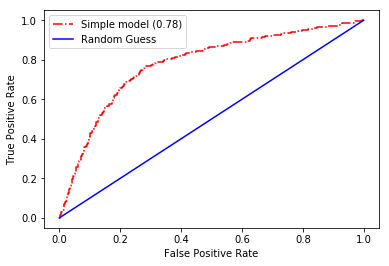

In [24]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            model2.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), model2.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

** ¿qué ocurre si la curva ROC se calcula con los datos de entrenamiento? ¿sale mejor? ¿por qué? **

Como vemos, en la curva ROC de los datos de entrenamiento, es excelente (es 1), por lo tanto si sale mucho mejor, esto se debe a que como está sobreajustando los datos de entrenemiento, es decir se los aprende de memoria, posteriormente los clasifica casi perfectamente, dejando una curva ROC óptima


             precision    recall  f1-score   support

          0       0.80      0.78      0.79      1041
          1       0.65      0.69      0.67       632

avg / total       0.75      0.74      0.75      1673



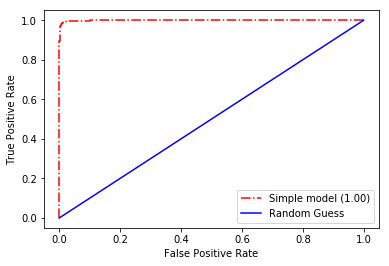

In [26]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            model2.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_train, 1), model2.predict_proba(X_tr)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

### Modelo CNN básico

In [27]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.losses import binary_crossentropy
from keras import optimizers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [28]:
print("X_train shape:", np.shape(X_train))
print("X_test shape: ", np.shape(X_test))
print("y_train shape:", np.shape(y_train))
print("y_test shape: ", np.shape(y_test))

X_train shape: (5018, 64, 64, 1)
X_test shape:  (1673, 64, 64, 1)
y_train shape: (5018, 2)
y_test shape:  (1673, 2)


** ¿Cuántos parámetros libres tiene en total cada capa del modelo? Comprueba que estos números coinciden con lo que te esperarías explicando y computando la cuenta que harías. **

**¿Por qué la salida de la primera capa Conv2D es 62x62x32 y no 64x64x32? ¿y por qué no es 64x64x1?**

El tamaño de la salida en la primera capa Conv2D es 62x62x32 en lugar de 64x64x32 debido al tamaño del kernel (3x3). El tamaño de la salida se reduce el tamaño del kernel menos uno, para cada dimension, así pues, para que fuera 64x64x32, el tamaño del kernel debería ser 1x1. El último valor indica el tamaño del espacio de salida o número de neuronas de la capa, que se indica cuando se llama a la función (el primer parámetro):

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
                 
Si queremos que sea 1, tan solo hay que indicarlo aquí. 

** ¿qué puedes hacer para que su salida sea 64x64x32?**

Modificar los paramentros de la función de la siguiente manera, a continuación, en la siguiente celda hay un ejemplo:

model.add(Conv2D(32, kernel_size=(1, 1),
                 activation='relu',
                 input_shape=input_shape))



In [48]:
batch_size = 128
epochs = 12
input_shape = (64,64,1)
num_classes = 2


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
23
model.compile(loss=binary_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 115202    
Total params: 134,018
Trainable params: 134,018
Non-trainable params: 0
_________________________________________________________________


**¿Por qué la tercera dimensión de la salida de la primera capa Conv2D es 64? ¿qué representa este número?**

Es 64 porque así lo indicamos en los parametros de la función y representa el espacio de salidas la capa convolucional, es decir el número de neuronas en la capa. 

*model.add(Conv2D(64, (1, 3), activation='relu'))*

**¿Por qué las capas maxpooling no tienen parámetros libres (parámetros a ajustar en el entrenamiento)?**

La capa maxpooling se encarga de reducir la escala según se indique en pool_size. Así pues para los valores (2,2) reduce a la mitad el tamaño en cada dimensionalidad. ///PORQUE no tiene parametros libres?!?!?

**¿Qué hace la capa flatten? ¿coincide su salida con lo que te esperarías? (haz la cuenta)**

La capa flatten lo que hace es "aplanar" el tamaño de las matrices, es decir, convertir un matriz de datos en un array, como la matriz es de tamaño 30x30x64=57600 nos queda un array de 57600 elementos, que coincide con la salida de la capa. 

**Entrena tu modelo: ¿qué resultados tienes ahora? ¿son mejores que los obtenidos por la regresión logística?**

